Import Libraries

In [11]:
# Imports
import os
import pandas as pd
import numpy as np
import re
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import lightgbm as lgb

1. Data Loading

In [12]:
# Load dataset
file_path = 'D:/College/Projects/Phishing_Detection/phishing-detection-backend/app/data/CEAS_08.csv'
data = pd.read_csv(file_path)


print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")
data.head()

Dataset contains 39154 rows and 7 columns.


,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


2. Preprocessing

In [13]:
# Function to clean text
def clean_text(text):
    """Preprocess email text by removing URLs, emails, HTML tags, and unnecessary characters."""
    text = text.lower()
    text = re.sub(r'http[s]?://\S+', '', text)  # Remove URLs
    text = re.sub(r'\S+@\S+', '', text)  # Remove email addresses
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Remove special characters
    return re.sub(r'\s+', ' ', text).strip()

# Apply preprocessing
data['body_cleaned'] = data['body'].apply(clean_text)
data.head()


,sender,receiver,date,subject,body,label,urls,body_cleaned
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,buck up your troubles caused by small dimensio...
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,upgrade your sex and pleasures with these tech...
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,the daily top from cnn com top videos and stor...
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,would anyone object to removing so from this l...
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1,welcomefastshippingcustomersupport


3. Feature Extraction

In [14]:
# Function to extract features
def extract_email_features(email):
    """Extract numerical features from email."""
    sender_length = len(email['sender']) if pd.notnull(email['sender']) else 0
    receiver_length = len(email['receiver']) if pd.notnull(email['receiver']) else 0
    subject_length = len(email['subject']) if pd.notnull(email['subject']) else 0
    body_length = len(email['body']) if pd.notnull(email['body']) else 0
    num_urls = email['urls'] if pd.notnull(email['urls']) else 0
    num_special_chars = sum([1 for char in email['body'] if pd.notnull(email['body']) and char in "!$%^&*()-_=+[]{};:<>"])
    
    return [sender_length, receiver_length, subject_length, body_length, num_urls, num_special_chars]

# Apply feature extraction
data['features'] = data.apply(extract_email_features, axis=1)

# Convert features to numpy array
X = np.array(data['features'].tolist())
y = data['label']

4. Exploratory Data Analysis

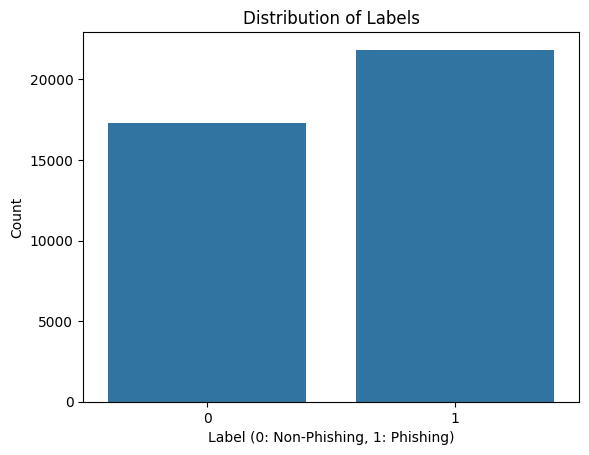

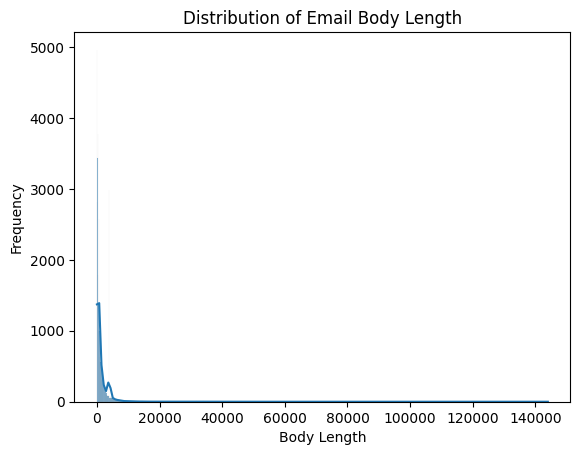

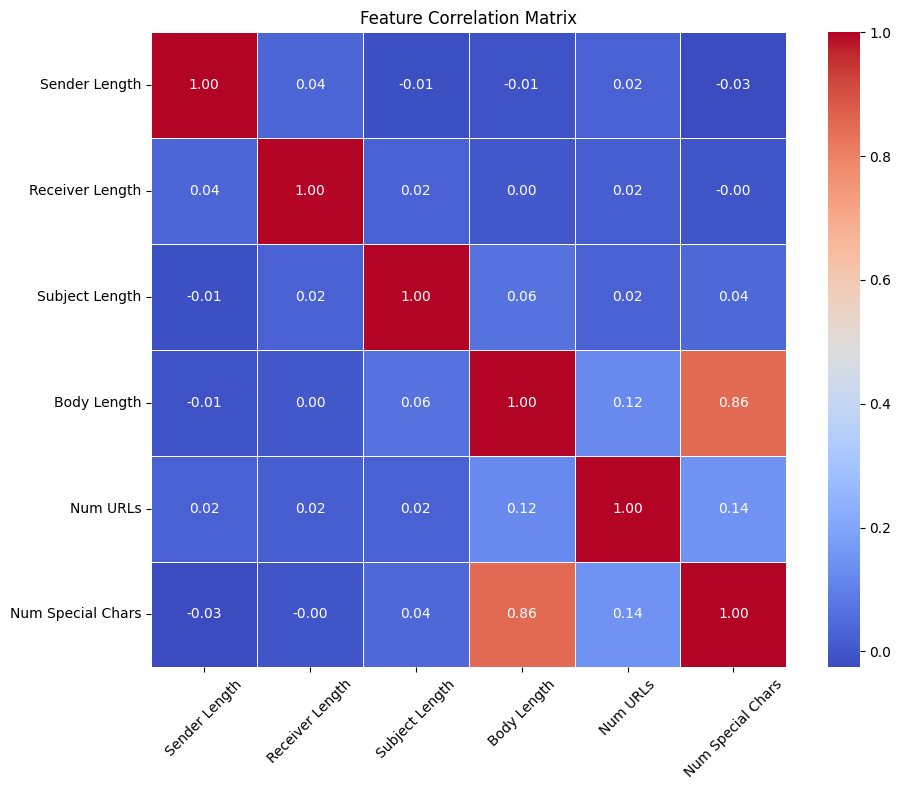

In [15]:
# Visualize label distribution
sns.countplot(x=data['label'])
plt.title("Distribution of Labels")
plt.xlabel("Label (0: Non-Phishing, 1: Phishing)")
plt.ylabel("Count")
plt.show()

# Analyze body length
sns.histplot(data['features'].apply(lambda x: x[3]), kde=True)
plt.title("Distribution of Email Body Length")
plt.xlabel("Body Length")
plt.ylabel("Frequency")
plt.show()

# Correlation Matrix
numerical_data = pd.DataFrame(X, columns=["Sender Length", "Receiver Length", "Subject Length", "Body Length", "Num URLs", "Num Special Chars"])
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

5. Train-Test Split

In [16]:
# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

6. Model Training

In [17]:
# Train LightGBM model
lightgbm_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42)
lightgbm_model.fit(X_train, y_train)

# Save model
joblib.dump(lightgbm_model, './saved/lightgbm_model.pkl')
print("LightGBM model saved!")

[LightGBM] [Info] Number of positive: 17501, number of negative: 13822
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 971
[LightGBM] [Info] Number of data points in the train set: 31323, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.558727 -> initscore=0.235996
[LightGBM] [Info] Start training from score 0.235996
LightGBM model saved!


In [18]:
# Scale data for autoencoder
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 10

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train autoencoder
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, validation_data=(X_test_scaled, X_test_scaled))

# Save autoencoder model
autoencoder.save('./saved/email_autoencoder_model.h5')
print("Autoencoder model saved!")

Epoch 1/50
979/979 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1214 - val_loss: 0.0101
Epoch 2/50
979/979 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step - loss: 0.0057 - val_loss: 0.0022
Epoch 3/50
979/979 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step - loss: 0.0020 - val_loss: 0.0014
Epoch 4/50
979/979 ━━━━━━━━━━━━━━━━━━━━ 1s 972us/step - loss: 0.0013 - val_loss: 8.8900e-04
Epoch 5/50
979/979 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step - loss: 7.8065e-04 - val_loss: 3.9319e-04
Epoch 6/50
979/979 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step - loss: 3.6889e-04 - val_loss: 2.9632e-04
Epoch 7/50
979/979 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step - loss: 3.0632e-04 - val_loss: 2.6538e-04
Epoch 8/50
979/979 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step - loss: 2.7099e-04 - val_loss: 2.3359e-04
Epoch 9/50
979/979 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step - loss: 2.3715e-04 - val_loss: 1.9681e-04
Epoch 10/50
979/979 ━━━━━━━━━━━━━━━━━━━━ 1s 910us/step - loss: 2.0834e-04 - val_loss: 1.4955e-04
Epoch 11/50
979/979 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - loss: 1.6429

Autoencoder model saved!


7. Model Evaluation

LightGBM Model Accuracy: 0.9819946367002937
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      3490
           1       0.98      0.99      0.98      4341

    accuracy                           0.98      7831
   macro avg       0.98      0.98      0.98      7831
weighted avg       0.98      0.98      0.98      7831



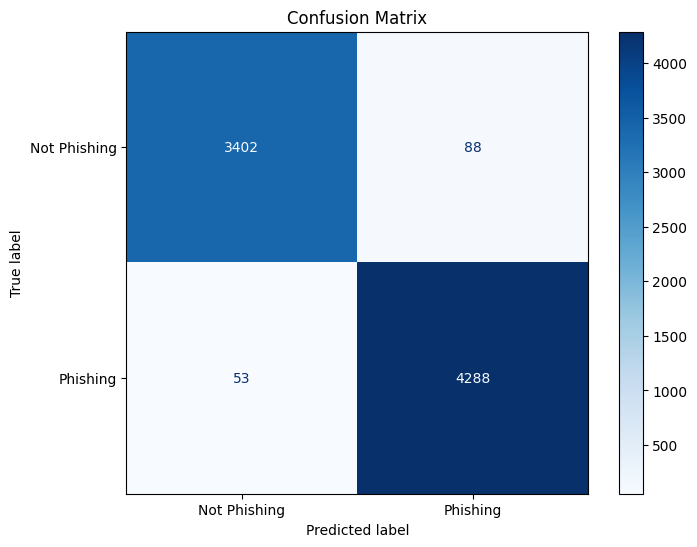

In [19]:
# Predictions
y_pred = lightgbm_model.predict(X_test)

# Metrics
print("LightGBM Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"])
disp.plot(cmap="Blues", ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

979/979 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step


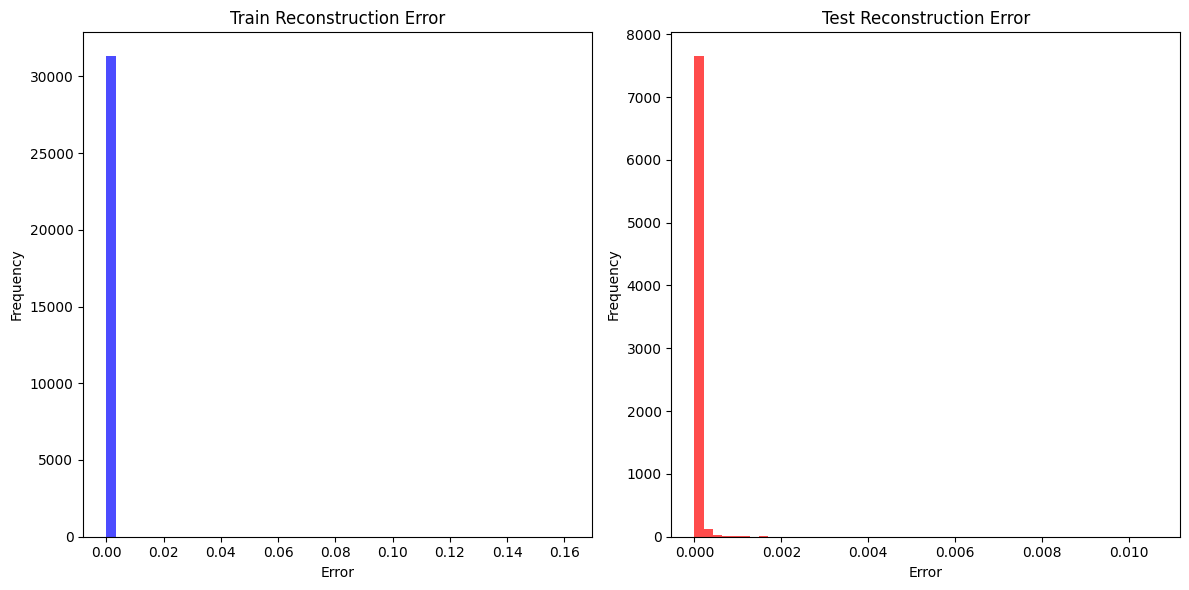

Number of anomalies detected: 392


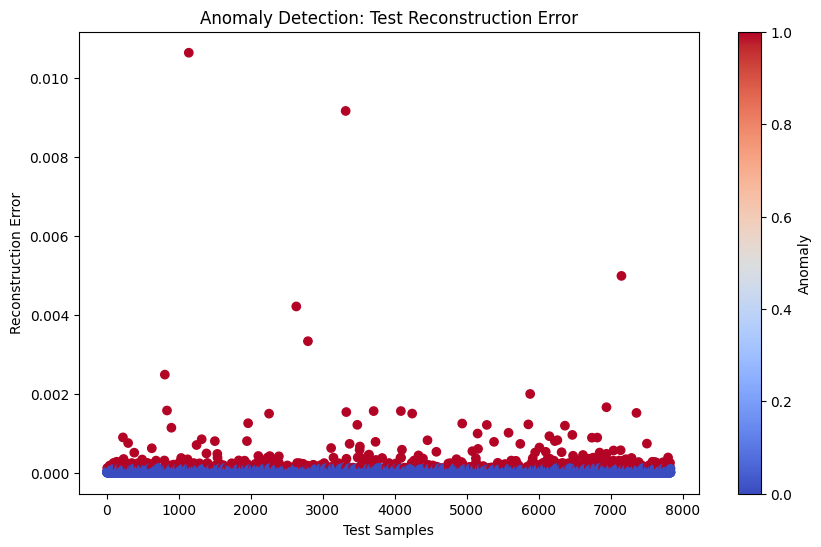

In [20]:
# Predict using the autoencoder (Reconstruction Error)
X_train_pred = autoencoder.predict(X_train_scaled)
X_test_pred = autoencoder.predict(X_test_scaled)

# Compute Reconstruction Errors for both Train and Test data
train_reconstruction_error = np.mean(np.power(X_train_scaled - X_train_pred, 2), axis=1)
test_reconstruction_error = np.mean(np.power(X_test_scaled - X_test_pred, 2), axis=1)

# Plot Reconstruction Error for both Train and Test data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(train_reconstruction_error, bins=50, color='blue', alpha=0.7, label='Train Error')
plt.title("Train Reconstruction Error")
plt.xlabel("Error")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(test_reconstruction_error, bins=50, color='red', alpha=0.7, label='Test Error')
plt.title("Test Reconstruction Error")
plt.xlabel("Error")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Visualizing Anomalies: Define threshold for anomalies based on reconstruction error
threshold = np.percentile(test_reconstruction_error, 95)  # 95th percentile as threshold for anomalies

# Identify anomalies (reconstruction error greater than threshold)
anomalies = test_reconstruction_error > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# Visualize anomalies in data
plt.figure(figsize=(10, 6))
plt.scatter(range(len(test_reconstruction_error)), test_reconstruction_error, c=anomalies, cmap='coolwarm')
plt.title("Anomaly Detection: Test Reconstruction Error")
plt.xlabel("Test Samples")
plt.ylabel("Reconstruction Error")
plt.colorbar(label='Anomaly')
plt.show()